# $Kerithmos$
Identifying numbers using keras
***

## TO DO:
* Evaluation and Saving Models
* Live download/unzipping of dataset for move to collab
* Implement something sexy like an [inception node](https://keras.io/getting-started/functional-api-guide/)

## Background
Here are a few useful papers
* http://proceedings.mlr.press/v28/wan13.pdf
* https://arxiv.org/pdf/1207.0580.pdf
* https://arxiv.org/pdf/1301.3557.pdf

## Setup
Here we do all our imports, as well as define any constants we use throughout the notebook.

In [1]:
# from tensorflow.keras import 
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
import tensorflow.keras as kr

In [2]:
# consts
DATA_DIR = "../data/"
IMG_DIMS = (32,32,3)
NUM_CLASSES = 10

In [5]:
# scale params
SCALE = True
GRAYSCALE = True
FEATUREWISE_CENTER = True
FEATUREWISE_STD_NORMALIZE = True
STANDARDIZE = True

## Load Data
Now we load the sample data from files and rearrange into appropriate format. Keras expects images in the form (samples,channels,x,y) or (samples,x,y,channels). Given the data is stored (x,y,channels,samples) we will use np.moveaxis to change it to a more conventional (and plotable) format.

In [3]:
kr.backend.set_image_data_format('channels_last') #this should be default, but just in case
train_data = loadmat(DATA_DIR + "train.mat")
test_data = loadmat(DATA_DIR + "test.mat")
X = train_data["X"]
X = np.moveaxis(X, -1, 0)
y = train_data["y"].flatten()-1 # matlab starts arrays at 1
X_test = test_data["X"]
X_test = np.moveaxis(X_test.T, -1, 0)
y_test = test_data["y"].flatten()-1 # matlab starts arrays at 1
X.shape #sanity check

(73257, 32, 32, 3)

Plot a random selection and it's corresponding label:

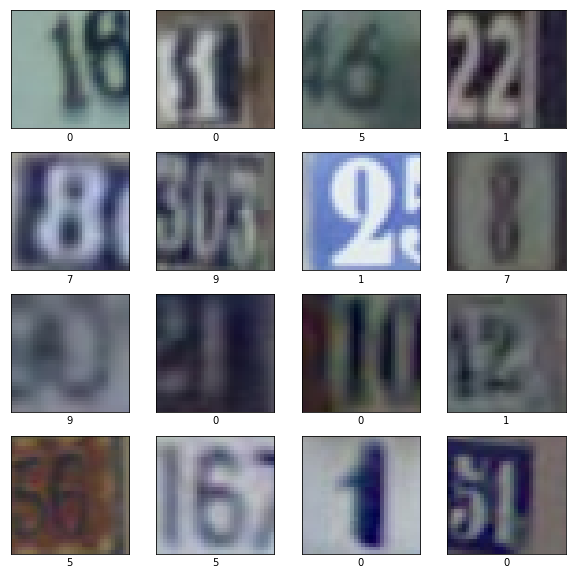

In [4]:
plt.figure(figsize=(10,10))
for i in range(16):
    rnd = np.random.randint(0,X.shape[0])
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[rnd])
    plt.xlabel(y[rnd]%10) #data treats 10 as 0
plt.show()

## Preprocess Data
Firstly we will scale data to $[0,1]$ and convert the image to grayscale, where applicable. The grayscale values were found online, but are mostly consistent with [grayscaling](https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale)

In [6]:
if SCALE:
    X = X / 255.0
    X_test = X_test / 255.0

In [7]:
if GRAYSCALE:
    X = np.dot(X[...,:3], [0.299, 0.587, 0.114])
    X_test = np.dot(X_test[...,:3], [0.299, 0.587, 0.114])
    X = X.reshape(-1,32,32,1)
    IMG_DIMS = (32,32,1)

We have the option of using a keras generator to augment images in batches. The datagen needs to be fit to the dataset for it to be able to compute normalizations. Note that using the datagen slows down training by an order of magnitude

In [8]:
datagen = kr.preprocessing.image.ImageDataGenerator(
    featurewise_center=FEATUREWISE_CENTER,
    featurewise_std_normalization=FEATUREWISE_STD_NORMALIZE,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False) #not kosher for numbers
datagen.fit(X)

Even if we don't want to use the datagen to augment samples during training, we can use it now to standardize the entire dataset.

In [9]:
if STANDARDIZE:
    X = datagen.standardize(X)

Show result of image preprocessing

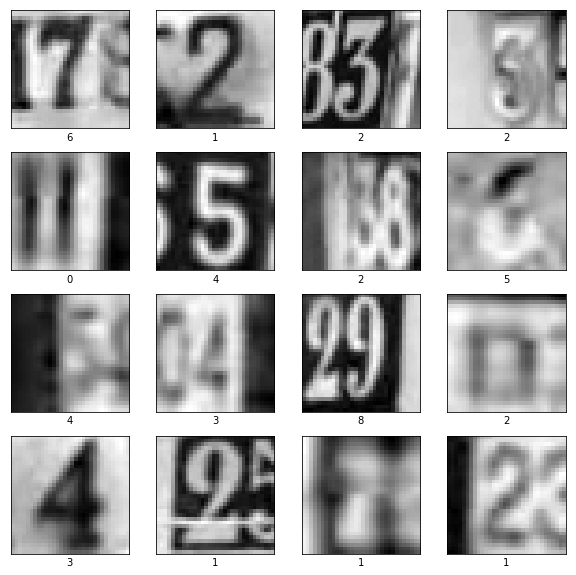

In [10]:
plt.figure(figsize=(10,10))
for i in range(16):
    rnd = np.random.randint(0,X.shape[0])
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if GRAYSCALE:
        plt.imshow(X[rnd][:,:,0],cmap='gray')
    else:
        plt.imshow(X[rnd])
    plt.xlabel(y[rnd]%10) #data treats 10 as 0
plt.show()

## Prepare Model
Here a few models are compiled under different names so they can be iteratively compared. Some parameters are constant between models, such as the loss function, and tracked metrics. As of writing there has been no attempt or desire to use any optimizer but Adam with default parameters.

In [11]:
# consts / params
optimizer = 'adam'
loss='sparse_categorical_crossentropy'
metrics=['accuracy']

In [12]:
# a standard MLP
NUM_UNITS = 128
NUM_LAYERS = 4
dense_model = kr.models.Sequential()
dense_model.add(kr.layers.Flatten(input_shape=IMG_DIMS))
for n in range(NUM_LAYERS):
    dense_model.add(kr.layers.Dense(NUM_UNITS, activation='relu'))
dense_model.add(kr.layers.Dense(NUM_CLASSES, activation='softmax'))
dense_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 182,026
Trainable params: 182,026
Non-trainable params: 0
_________________________________________________________________


In [13]:
# a standard CNN
NUM_FILTERS = 64
NUM_LAYERS = 4
cnn = kr.models.Sequential()
cnn.add(kr.layers.Dropout(.2, input_shape=IMG_DIMS))
for n in range(NUM_LAYERS):
    nf = NUM_FILTERS * (2**(n))
    cnn.add(kr.layers.Conv2D(nf, kernel_size=3, activation='relu', padding='same'))
    cnn.add(kr.layers.MaxPooling2D(pool_size=(2,2),padding='same'))
    cnn.add(kr.layers.BatchNormalization())
cnn.add(kr.layers.Flatten())
cnn.add(kr.layers.Dense(NUM_CLASSES, activation='softmax'))
cnn.compile(optimizer=optimizer, loss=loss, metrics=metrics)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        3200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        200768    
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
__________

This architecture, which I am calling $KrizNet$ is modeled after a CNN architecture used by Krizhevsky in several papers on feature detection. The network proposed in https://arxiv.org/pdf/1207.0580.pdf includes:
* 20% dropout on input layer, 50% on hidden layers
* 3 convolutional layers with max pooling
* a fully connected output layer before softmax

However here this is modified with a few modern features:
* 4 convolutional layers
* 3x3 convolutions are stacked to emulate a 5x5
* The number of filters in successive layers are doubled

_I am still tweaking the activation layer by experimenting with variations on ReLU but so far elu shows no improvement, and selu seems to perform worse even with the suggested weight initialization and alpha dropout, but I only tested briefly_

In [14]:
#
NUM_FILTERS = 64
OUTPUT_UNITS = 256
krizNet = kr.models.Sequential()
krizNet.add(kr.layers.Dropout(.2, input_shape=IMG_DIMS))
# conv 1
krizNet.add(kr.layers.Conv2D(NUM_FILTERS,5, activation='elu', padding='same', input_shape=IMG_DIMS))
krizNet.add(kr.layers.Conv2D(NUM_FILTERS,5, activation='elu', padding='same', input_shape=IMG_DIMS))
krizNet.add(kr.layers.MaxPooling2D( padding='same'))
krizNet.add(kr.layers.BatchNormalization())
krizNet.add(kr.layers.Dropout(.5, input_shape=IMG_DIMS))

#conv 2
krizNet.add(kr.layers.Conv2D(NUM_FILTERS*2,3, activation='elu', padding='same', input_shape=IMG_DIMS))
krizNet.add(kr.layers.Conv2D(NUM_FILTERS*2,3, activation='elu', padding='same', input_shape=IMG_DIMS))
krizNet.add(kr.layers.MaxPooling2D(padding='same'))
krizNet.add(kr.layers.BatchNormalization())
krizNet.add(kr.layers.Dropout(.5, input_shape=IMG_DIMS))

# conv 3
krizNet.add(kr.layers.Conv2D(NUM_FILTERS*4,3, activation='elu', padding='same', input_shape=IMG_DIMS))
krizNet.add(kr.layers.Conv2D(NUM_FILTERS*4,3, activation='elu', padding='same', input_shape=IMG_DIMS))
krizNet.add(kr.layers.MaxPooling2D(padding='same'))
krizNet.add(kr.layers.BatchNormalization())
krizNet.add(kr.layers.Dropout(.5, input_shape=IMG_DIMS))

# conv 4
krizNet.add(kr.layers.Conv2D(NUM_FILTERS*8,3, activation='elu', padding='same', input_shape=IMG_DIMS))
krizNet.add(kr.layers.Conv2D(NUM_FILTERS*8,3, activation='elu', padding='same', input_shape=IMG_DIMS))
krizNet.add(kr.layers.MaxPooling2D(padding='same'))
krizNet.add(kr.layers.BatchNormalization())
krizNet.add(kr.layers.Dropout(.5, input_shape=IMG_DIMS))

#out
krizNet.add(kr.layers.Flatten())
krizNet.add(kr.layers.Dense(OUTPUT_UNITS, activation='elu'))
krizNet.add(kr.layers.Dropout(.5, input_shape=IMG_DIMS))
krizNet.add(kr.layers.Dense(NUM_CLASSES, activation='softmax'))
krizNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
krizNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)       73856     
__________

## Train Model

Currently, I haven't trained KrizNet beyond 20 or so epochs, at which point it starts overfitting with around 93% accuracy. Doing so takes about 30 minutes on my 1050TI GPU.

In [15]:
# model = cnn
model = krizNet
EPOCHS = 10

Train on 58605 samples, validate on 14652 samples
Epoch 1/10
58605/58605 [==============================] - 94s 2ms/step - loss: 1.4522 - acc: 0.5724 - val_loss: 0.4939 - val_acc: 0.8473
Epoch 2/10
58605/58605 [==============================] - 90s 2ms/step - loss: 0.6814 - acc: 0.7873 - val_loss: 0.4295 - val_acc: 0.8675
Epoch 3/10
58605/58605 [==============================] - 89s 2ms/step - loss: 0.5951 - acc: 0.8171 - val_loss: 0.3542 - val_acc: 0.8928
Epoch 4/10
58605/58605 [==============================] - 89s 2ms/step - loss: 0.5162 - acc: 0.8433 - val_loss: 0.3283 - val_acc: 0.9019
Epoch 5/10
58605/58605 [==============================] - 89s 2ms/step - loss: 0.4483 - acc: 0.8640 - val_loss: 0.3246 - val_acc: 0.9038
Epoch 6/10
58605/58605 [==============================] - 89s 2ms/step - loss: 0.4048 - acc: 0.8787 - val_loss: 0.2915 - val_acc: 0.9174
Epoch 7/10
58605/58605 [==============================] - 90s 2ms/step - loss: 0.3673 - acc: 0.8919 - val_loss: 0.2747 - val_acc

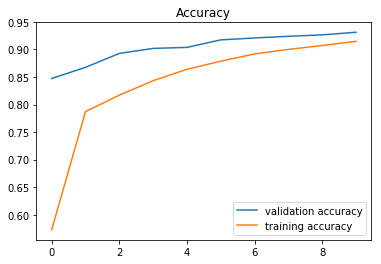

In [16]:
history = model.fit(X,y,epochs=EPOCHS, validation_split=0.2)
# history = model.fit_generator(datagen.flow(X, y, batch_size=32), epochs=EPOCHS, steps_per_epoch=len(X)) #just... don't
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.legend(['validation accuracy', 'training accuracy'])
plt.title("Accuracy")
pass

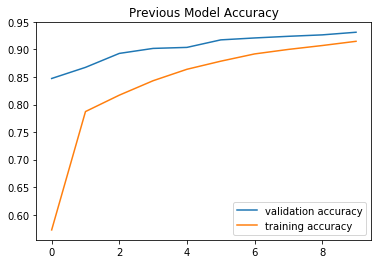

In [17]:
# this cell exists so I have a reference to the last training session to compare to when I tweak something
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.legend(['validation accuracy', 'training accuracy'])
plt.title("Previous Model Accuracy")
pass

## Evaluate Model

## Save Model